<a href="https://colab.research.google.com/github/teerasitk/01205415/blob/main/TradeSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install
1. yfinance for accessing yahoo finance data
2. tensortrade for trade simulation

In [1]:
!pip install yfinance
!pip install tensortrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.6/32.6 MB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00
  Created wheel for tensortrade: filename=tensortrade-1.0.3-py3-none-any.whl size=134844 sha256=86e61cc0a195292030638dcd28708fe7a634e883ce521d35681ba6176ca22c9d
  Stored in directory: /root/.cache/pip/wheels/7f/a7/75/792c00b8bcd136448db22cd2ca4b4bf0856a58a7dea881bcfc
Successfully built tensortrade


# import Python libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensortrade.env.default as default
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

# Download AOT from 2015 to 2023

*   List item
*   List item



In [3]:
data_frame = yf.download("AOT.BK", "2015-01-01", "2023-12-31")
data_frame.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-05,28.0,28.000000,27.200001,27.299999,24.920393,24970000
2015-01-06,26.9,27.400000,26.700001,27.200001,24.829113,24309000
2015-01-07,27.5,28.299999,27.500000,28.299999,25.833229,20682000
2015-01-08,28.9,29.000000,28.600000,28.900000,26.380930,23039000
2015-01-09,29.1,29.299999,28.900000,29.100000,26.563498,34221000


# Build symbol
1. THB for Thai Baht
2. AOT for Airports of Thailand

In [4]:
THB = Instrument(symbol="THB", precision=2, name="Thai Baht")
AOT = Instrument(symbol="AOT", precision=2, name="Airports of Thailand")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
set_market = Exchange("set", service=execute_order,
                      options=ExchangeOptions(commission=0.0001))
# build exchange market
# commission is to 0.01%
buy_sell_prices = data_frame['Close'].tolist()
stream_prices = Stream.source(buy_sell_prices, dtype='float').rename("THB-AOT")
set_market = set_market(stream_prices)

# Build feature from historical prices

In [6]:
hist_len = 90 # look back 1 quarter
close_price = data_frame["Close"]
high_price = data_frame["High"].tolist()
low_price = data_frame["Low"].tolist()
streams = [Stream.source(close_price.shift(c)).rename(f"lag{c:02d}") for c in range(1, hist_len+1)]
streams.append(Stream.source(high_price,
                         dtype="float").rename("max_of_day"))
streams.append(Stream.source(low_price,
                         dtype="float").rename("min_of_day"))

# Data feed from historical prices

In [ ]:
feed = DataFeed(streams)
feed.next()

In [ ]:
feed.next()

# Initialize portfolio with 100k THB and 0 Shares of AOT




In [160]:
cash = Wallet(set_market, 100_000 * THB)
asset = Wallet(set_market, 0 * AOT)
portfolio = Portfolio(THB, [cash,
                            asset])

In [161]:
portfolio.balances

[100000.00 THB, 0.00 AOT]

# Build Trading Environment

In [162]:
env = default.create(
        portfolio=portfolio, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in and out
        # I made some changes here
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )


# Build a trading strategies
Here, we buy if hist_len average close price is lower than maximum price of the day and sell if the his_len average is higer than minimum price of the day

In [152]:
env.action_space # there only two possible action 0: sell and 1: buy

Discrete(2)

In [163]:
done = False
obs = env.reset()
cnt = 0
actions = [0]
status = "No Position"
while not done:
  hist_price = obs[0][:hist_len]
  max_day = obs[0][hist_len]
  min_day = obs[0][-1]
  avg_price = np.mean(hist_price)
  last_action = actions[-1]
  if (avg_price < max_day) and (status == "No Position"):
    action = 1 # all in
    status = "Hold"
  elif (avg_price < max_day) and (status == "Hold"):
    action = 1 # keep holding
  elif  (avg_price > min_day) and (status == "Hold"):
    action = 0 # all out
    status = "No Position"
  else:
    action = 0
    status = "No Position"
  actions.append(action)
  obs, reward, done, info = env.step(action)

portfolio.ledger.as_frame().head(7)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,56b41530-9723-444f-92bb-8029388b929a,1,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,56b41530-9723-444f-92bb-8029388b929a,1,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,56b41530-9723-444f-92bb-8029388b929a,1,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,56b41530-9723-444f-92bb-8029388b929a,1,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 30.10),3321.93 AOT,0.00 AOT,3321.93 AOT,3321.93 AOT
4,56b41530-9723-444f-92bb-8029388b929a,1,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,56b41530-9723-444f-92bb-8029388b929a,1,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3321.93 AOT,3321.93 AOT,0.00 AOT,0.00 AOT
6,011bfbde-100b-413b-8f42-3f9545cb3afd,6,set:AOT/free,set:AOT/locked,LOCK (LOCK FOR ORDER),3321.93 AOT,0.00 AOT,3321.93 AOT,3321.93 AOT


In [164]:
df = pd.DataFrame(portfolio.performance)
df = df.T
df.head()

,set:/THB-AOT,set:/THB:/free,set:/THB:/locked,set:/THB:/total,set:/AOT:/free,set:/AOT:/locked,set:/AOT:/total,set:/AOT:/worth,net_worth,base_symbol
0,30.1,100000.0,0.0,100000.0,0.0,0.0,0.0,0.0,100000.0,THB
1,30.6,0.0,0.0,0.0,3321.93,0.0,3321.93,101651.059267,101651.059267,THB
2,30.299999,0.0,0.0,0.0,3321.93,0.0,3321.93,100654.476466,100654.476466,THB
3,29.4,0.0,0.0,0.0,3321.93,0.0,3321.93,97664.740733,97664.740733,THB
4,29.200001,0.0,0.0,0.0,3321.93,0.0,3321.93,97000.358534,97000.358534,THB


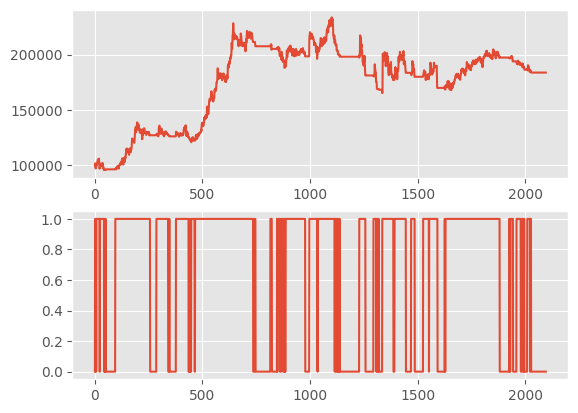

In [165]:
plt.subplot(2,1,1)
plt.plot(df.net_worth)
plt.subplot(2,1,2)
plt.plot(actions)

# Buy and Hold Strategy

In [166]:
cash = Wallet(set_market, 100_000 * THB)
asset = Wallet(set_market, 0 * AOT)
portfolio2 = Portfolio(THB, [cash,
                            asset])
env2 = default.create(
        portfolio=portfolio2, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in or out
        # I changed from simple order to BUY-SELL Order
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )
portfolio2.balances

[100000.00 THB, 0.00 AOT]

In [167]:
done = False
obs = env2.reset()
cnt = 0
actions = []
action = 1
while not done:
  actions.append(action)
  obs, reward, done, info = env2.step(action)
  action = 1
portfolio2.ledger.as_frame().head(7)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,4e4dece4-452e-40d6-acc1-95ee21314819,1,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,4e4dece4-452e-40d6-acc1-95ee21314819,1,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,4e4dece4-452e-40d6-acc1-95ee21314819,1,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,4e4dece4-452e-40d6-acc1-95ee21314819,1,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 30.10),3321.93 AOT,0.00 AOT,3321.93 AOT,3321.93 AOT
4,4e4dece4-452e-40d6-acc1-95ee21314819,1,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,4e4dece4-452e-40d6-acc1-95ee21314819,1,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3321.93 AOT,3321.93 AOT,0.00 AOT,0.00 AOT


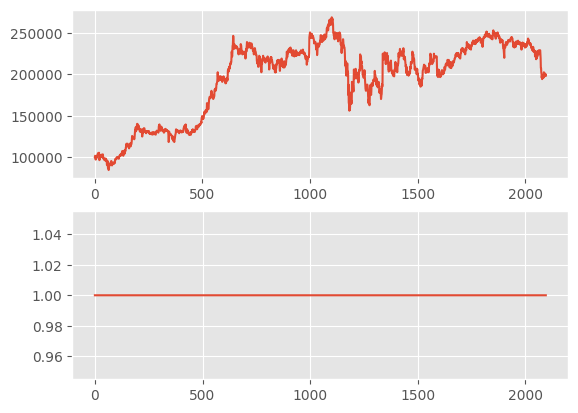

In [168]:
df2 = pd.DataFrame(portfolio2.performance)
df2 = df2.T
plt.subplot(2,1,1)
plt.plot(df2.net_worth)
plt.subplot(2,1,2)
plt.plot(actions)

# comapring between two strategies

Text(0.5, 1.0, 'Gain (Loss) comparing to Buy and Hold')

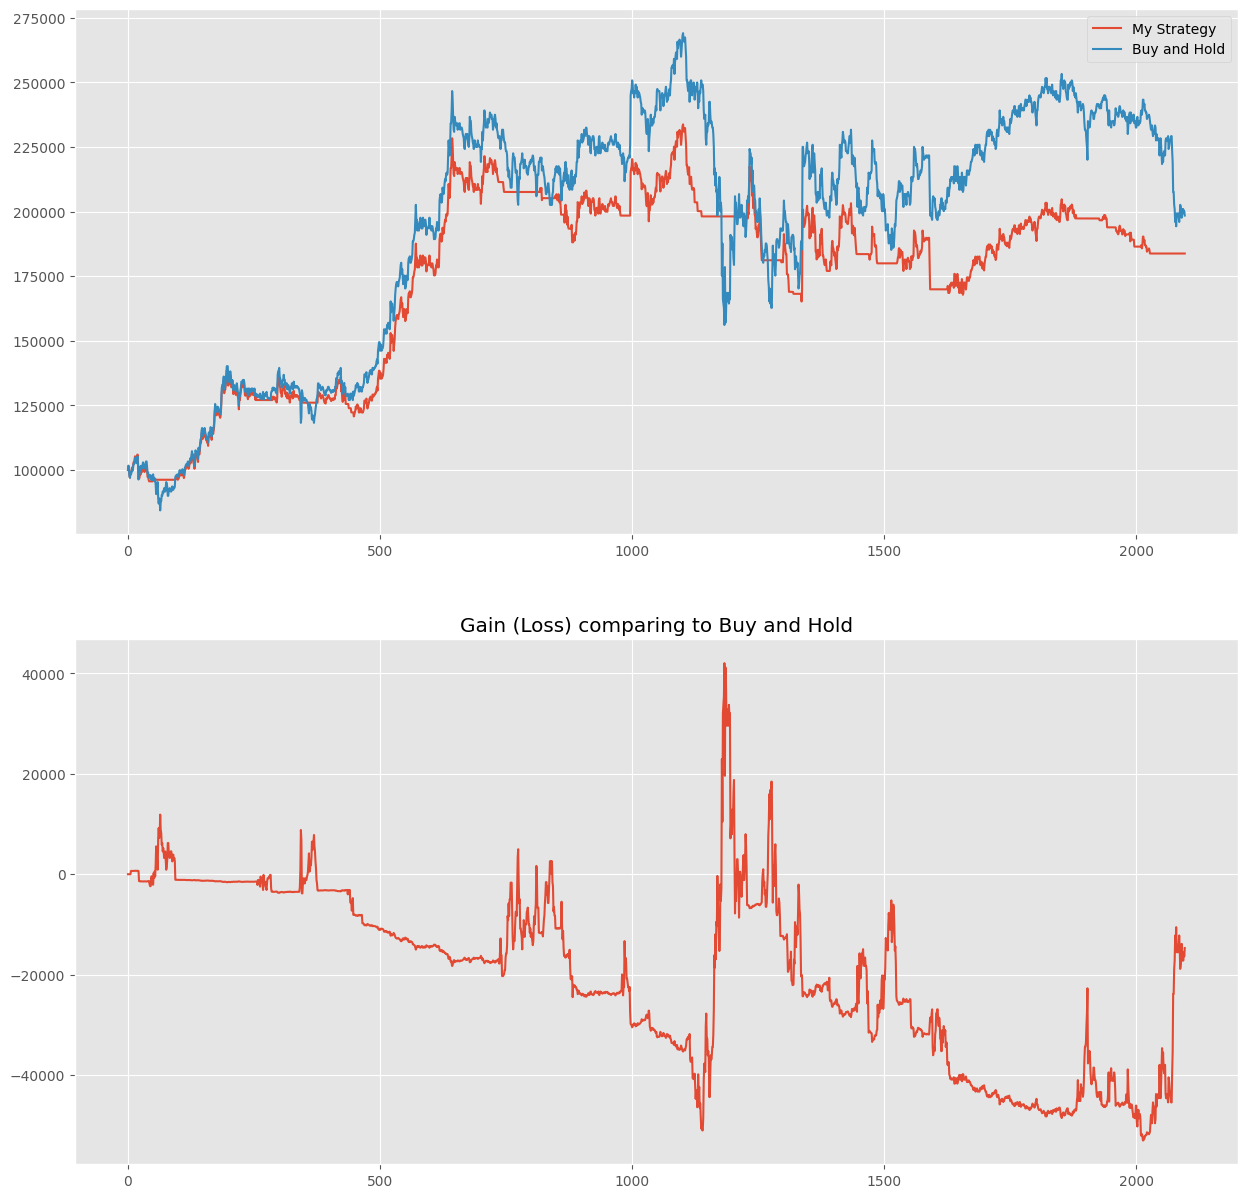

In [169]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(df.net_worth, label="My Strategy")
plt.plot(df2.net_worth, label="Buy and Hold")
plt.legend()
plt.subplot(2,1,2)
plt.plot(df.net_worth-df2.net_worth)
plt.title("Gain (Loss) comparing to Buy and Hold")


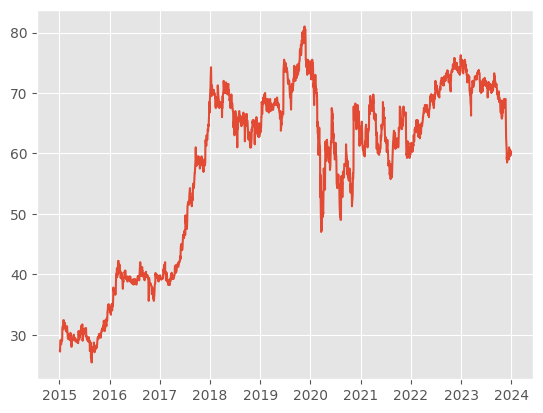

In [20]:
plt.plot(data_frame.Close)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


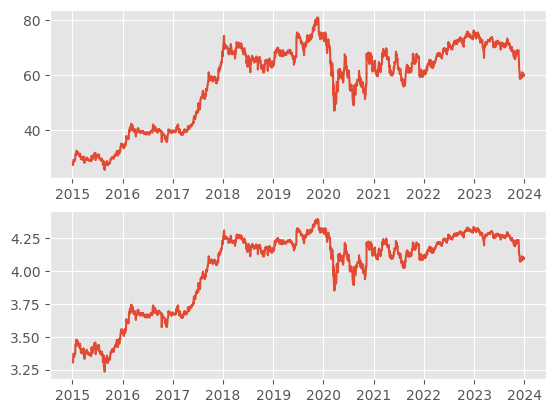

In [21]:
price = data_frame.Close
plt.subplot(2,1,1)
plt.plot(price)
plt.subplot(2,1,2)
plt.plot(np.log(price))

# Detrend data

In [22]:
from statsmodels.tsa.stattools import adfuller
log_price = np.log(price)
detrend = log_price.diff(1).dropna()
result = adfuller(detrend)
print('ADF statistic: ', result[0])
print('p-value: %.3f' % result[1])

ADF statistic:  -9.630527198471755
p-value: 0.000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


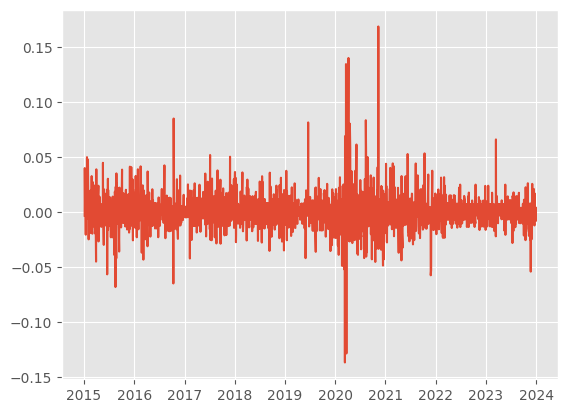

In [23]:
plt.plot(detrend)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


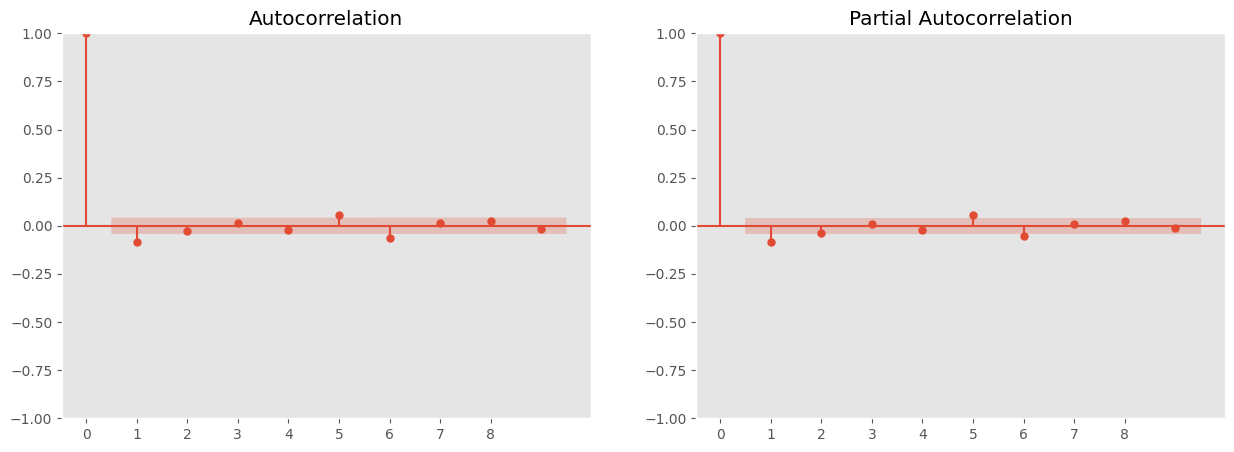

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes  = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
f1 = plot_acf(detrend, lags=9, ax=axes[0])
f2 = plot_pacf(detrend, lags=9, ax=axes[1])
axes[0].set_xticks(np.arange(9))
axes[0].grid()
axes[1].set_xticks(np.arange(9))
axes[1].grid()

In [26]:
import itertools    # for looping over all possible p and q
import warnings # disable warning
import statsmodels.tsa.arima.model as arima_model # main arma model
warnings.simplefilter("ignore") # ignorall warning

def armaParameterSearch(data:pd.Series,
                        ar_order:int,
                        ma_order:int): #
  p = range(ar_order + 1) # 0,..., ar_oder
  q = range(ma_order + 1) # 0, ... , ma_order
  parameter_spaces = list(itertools.product(p,q)) # pairs of all possible values
  best_aic, pq, best_result = None, None, None # initilize to None
  for (p,  q) in parameter_spaces: # all p,q pairs
    try :
      model = arima_model.ARIMA(data, order=(p,0,q), trend="t") # Linear Trend
      result = model.fit() # fit with data
      if (best_aic is None) or (result.aic < best_aic):
        # if better aic
        best_aic = result.aic
        pq = (p,q)
        best_result = result
    except:
      continue
  return best_aic, pq, best_result

In [27]:
best_aic, pq, best_arma_result = armaParameterSearch(data=detrend,
                                                     ar_order=5,
                                                     ma_order=5)
print(pq)

(1, 5)


In [28]:
best_arma_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2186
Model:                 ARIMA(1, 0, 5)   Log Likelihood                5914.585
Date:                Wed, 24 Jan 2024   AIC                         -11813.169
Time:                        07:43:12   BIC                         -11767.651
Sample:                             0   HQIC                        -11796.531
                               - 2186                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.828e-08   2.81e-07      0.172      0.864   -5.03e-07    5.99e-07
ar.L1         -0.6140      0.122     -5.022      0.000      -0.854      -0.374
ma.L1          0.5315      0.121      4.388      0.000       0.294       0.769
ma.L2         -0.0808      0.019     -4.152      0.000      -0.119      -0.043
ma.L3         -0.0037      0.018     -0.202      0.840      -0.039       0.032
ma.L4         -0.0106      0.015     -0.707      0.479      -0.040       0.019
ma.L5          0.0469      0.018      2.631      0.009       0.012       0.082
sigma2         0.0003   3.17e-06     82.078      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             22393.74
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
cash = Wallet(set_market, 100_000 * THB)
asset = Wallet(set_market, 0 * AOT)

In [125]:
portfolio3 = Portfolio(THB, [cash,
                            asset])
env3 = default.create(
        portfolio=portfolio3, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in or out
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )


In [126]:
for k in range(10):
  print(env3.action_space.sample())

0
0
1
1
1
0
1
1
1
0


In [128]:
done = False
obs = env3.reset()
cnt = 0
actions = [0]
status = "No Position"
action = 0
while not done:
  hist_prices = obs[0][:hist_len]
  max_day = obs[0][-2]
  min_day = obs[0][-1]
  log_price = np.log(hist_prices)
  detrend = log_price[0:-1] - log_price[1:]
  model = arima_model.ARIMA(detrend, order=(1,0,5), trend="t")
  current_arma_result = model.fit()
  forecast = best_arma_result.get_forecast(steps=1)
  log_conf = forecast.conf_int()
  log_lower_conf = log_conf["lower Close"].values[0]
  log_upper_conf = log_conf["upper Close"].values[0]
  forcasted_upper_price = np.exp(log_upper_conf) * hist_prices[0]
  forcasted_lower_price = np.exp(log_lower_conf) * hist_prices[0]
  if (status == "No Position") and (forcasted_upper_price < max_day):
    action = 1 # all in
    status = "Hold"
  elif (status == "Hold") and (forcasted_lower_price > min_day):
    action = 0 # all out
    status = "No Position"
  else:
    pass
  #action = env3.action_space
  actions.append(action)
  obs, reward, done, info = env3.step(action)
  print(action, reward, status, info, portfolio3.balances )
portfolio3.ledger.as_frame().head(7)

0 0.0 No Position {'step': 1, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 2, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 3, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 4, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 5, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 6, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 7, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 8, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 9, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 10, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 11, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 12, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
0 0.0 No Position {'step': 13, 'net_worth': 10000

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,c9d44471-0816-4b65-a44b-12120bc9f497,63,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,c9d44471-0816-4b65-a44b-12120bc9f497,63,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,c9d44471-0816-4b65-a44b-12120bc9f497,63,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,c9d44471-0816-4b65-a44b-12120bc9f497,63,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 26.80),3730.97 AOT,0.00 AOT,3730.97 AOT,3730.97 AOT
4,c9d44471-0816-4b65-a44b-12120bc9f497,63,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,c9d44471-0816-4b65-a44b-12120bc9f497,63,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3730.97 AOT,3730.97 AOT,0.00 AOT,0.00 AOT
6,68964d81-72fa-412d-97ae-21623eb038fb,65,set:AOT/free,set:AOT/locked,LOCK (LOCK FOR ORDER),3730.97 AOT,0.00 AOT,3730.97 AOT,3730.97 AOT


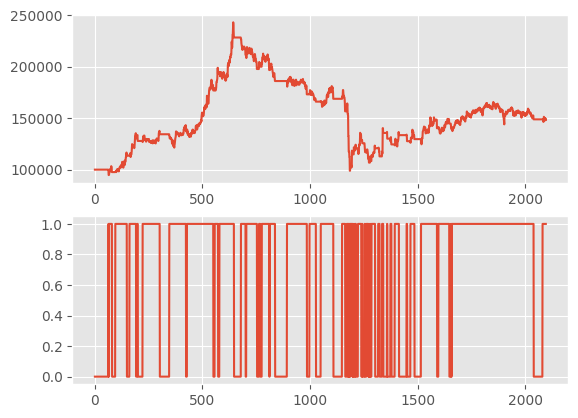

In [132]:
df3 = pd.DataFrame(portfolio3.performance)
df3 = df3.T
plt.subplot(2,1,1)
plt.plot(df3.net_worth)
plt.subplot(2,1,2)
plt.plot(actions)

In [133]:
print(f"{df3.net_worth.iloc[-1]:,.2f}")

148,225.41


In [134]:
ret = df3.net_worth.pct_change(1).dropna()
sharp_ration = ret.mean() / ret.std()
print(f"Sharp ratio: {sharp_ration *np.sqrt(365):0.3f}")

Sharp ratio: 0.401
